In [3]:
import sys
#sys.path.append('/home/ywkim/anaconda3/lib/python3.10/site-packages')

import torch
import torch_pruning as tp
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from train import original_train
from test import test
from pruning import pruning
from pruning_finetuning import pruning_finetuning
from experi_pruning_finetuning import experi_pruning_finetuning
from quantization import quantize_qint8

import matplotlib.pyplot as plt
import numpy as np
import random
#from ptflops import get_model_complexity_info
import copy

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)



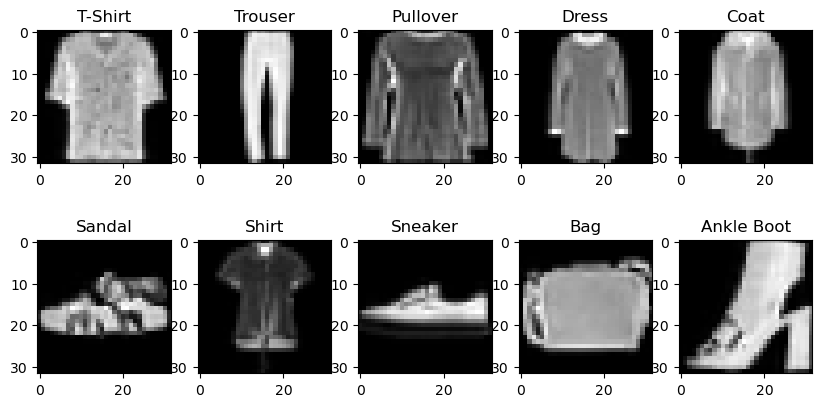

In [4]:
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root = "data", train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = "data", train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = trainset, shuffle = True, batch_size = 32)
test_loader = torch.utils.data.DataLoader(dataset = testset, shuffle = False, batch_size = 32)


label_tags = {
    0:'T-Shirt',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot'
}

iter_trainloader = iter(train_loader)
imgs, labels = next(iter_trainloader)
imgs_2, labels_2 = next(iter_trainloader)

figure = plt.figure(figsize = (10,5))
rows, cols = (2,5)
for i in range(0, 10):
    img_idxs = np.argwhere(labels == i)[0]
    if img_idxs.shape[0] == 0:
        print('두번째 loader')
        img_idx = np.argwhere(labels_2 == i)[0][0]
    else: 
        img_idx = img_idxs[0]
    figure.add_subplot(rows, cols, i+1)
    plt.title(label_tags[i])
    plt.imshow(imgs[img_idx].squeeze(), cmap = 'grey')
plt.show()



In [5]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
    
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Base model train & test

< four metrics >

- accuracy
- inference time
- n_params
- MACs

In [9]:
"""
origin_model = LeNet_5().to(device)
origin_model = original_train(origin_model, device, train_loader)

acc, inference_time = test(origin_model, device, test_loader)
print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
macs, nparams = tp.utils.count_ops_and_params(origin_model, torch.randn(1, 1, 32, 32).to(device))
print('n_params:', nparams)
print('macs:', macs)

torch.save(origin_model.state_dict(), 'origin_model.pth')
"""


accuracy: 89.230
inference time: 6.880μs
n_params: 61706
macs: 429342.0


In [7]:
def get_memory_used():
    return f'{round(torch.cuda.memory_allocated() / 1024**2, 2)}MB'

get_memory_used()

'0.0MB'

In [8]:
import warnings
warnings.filterwarnings('ignore')
                        
origin_model = LeNet_5().to(device)
origin_model.load_state_dict(torch.load('origin_model.pth'))

get_memory_used()

'0.24MB'

# [ Pruning ] 

### * Memory usage across pruning ratio

In [4]:
model = copy.deepcopy(origin_model)

mem_before = get_memory_used()
model_, acc_, params_, mmac_, inference_time_, df_ = pruning_finetuning(model, 0.8, device, test_loader, 5, 1e-4)
mem_after = get_memory_used()

print("Memory usage Before Pruning: ", mem_before)
print("Memory usage After Pruning: ", mem_after)
print("Effect of pruning on Memory size: ", float(mem_after[:-2]) - float(mem_before[:-2]), 'MB')

Memory usage Before Pruning:  0.48MB
Memory usage After Pruning:  16.84MB
Effect of pruning on Memory size:  16.36 MB


### * Finetuning learning rate comparison on pruning ratio 0.5

In [25]:
# pruning + finetuning
model = copy.deepcopy(origin_model)
model_4, acc_4, params_4, mmac_4, inference_time_4, df_4 = pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)

model = copy.deepcopy(origin_model)
model_5, acc_5, params_5, mmac_5, inference_time_5, df_5 = pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-5)

model = copy.deepcopy(origin_model)
model_6, acc_6, params_6, mmac_6, inference_time_6, df_6 = pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-6)

In [33]:
import pandas as pd
pd.DataFrame({"Accuracy" : [acc_4[0].round(), acc_4[-1], acc_5[-1], acc_6[-1]]},
             index = ['Base', 'lr * 1/10', 'lr * 1/100', 'lr * 1/1000'])

,Accuracy
Base,89.0
lr * 1/10,88.45
lr * 1/100,83.07
lr * 1/1000,69.6


### * Iterative step comparison on pruning ratio 0.5

In [69]:
model = copy.deepcopy(origin_model)
model_5, acc_5, params_5, mmac_5, inference_time_5, df_5 = pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)

model = copy.deepcopy(origin_model)
model_4, acc_4, params_4, mmac_4, inference_time_4, df_4 = pruning_finetuning(model, 0.5, device, test_loader, 4, 1e-4)

model = copy.deepcopy(origin_model)
model_3, acc_3, params_3, mmac_3, inference_time_3, df_3 = pruning_finetuning(model, 0.5, device, test_loader, 3, 1e-4)

model = copy.deepcopy(origin_model)
model_2, acc_2, params_2, mmac_2, inference_time_2, df_2 = pruning_finetuning(model, 0.5, device, test_loader, 2, 1e-4)

model = copy.deepcopy(origin_model)
model_1, acc_1, params_1, mmac_1, inference_time_1, df_1 = pruning_finetuning(model, 0.5, device, test_loader, 1, 1e-4)

In [72]:
pd.DataFrame({'Acc(%)':[acc_1[0], acc_1[-1], acc_2[-1], acc_3[-1], acc_4[-1], acc_5[-1]]},
             index = ['Base'] + list(range(1, 6)))

,Acc(%)
Base,89.229996
1,86.52
2,85.74999
3,87.27
4,88.159996
5,88.45


### * Performance comparison based on the Scope of Layer-wise Pruning

1) Pruning applied to the entire layer (Conv + Linear)
2) Pruning applied to Conv layers only
3) Pruning applied to Linear layers only

In [4]:
model = copy.deepcopy(origin_model)
_, acc_except_last_linear_layer, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, "except_last_linear_layer")

model = copy.deepcopy(origin_model)
_, acc_except_all_linear_layer, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, "except_all_linear_layer")

model = copy.deepcopy(origin_model)
_, acc_except_all_conv_layer, _, _, _, _ = experi_pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4, "except_all_conv_layer")

In [13]:
import pandas as pd
pd.DataFrame({'Acc(%)':[acc_except_last_linear_layer[0], acc_except_last_linear_layer[-1], acc_except_all_linear_layer[-1], acc_except_all_conv_layer[-1]]},
             index = ['Base', 'conv+linear pruning', 'only conv pruning', 'only linear pruning'])

,Acc(%)
Base,89.229996
conv+linear pruning,88.45
only conv pruning,89.479996
only linear pruning,93.28


# pruning ratio : 50%

In [9]:
# Just Pruning, Before finetuning
model = copy.deepcopy(origin_model)
_model_50, _acc_50, _params_50, _mmac_50, _inference_time_50, _df_50 = pruning(model, 0.5, device, test_loader, 5)
_df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,10.814095
step 1,88.81,48737,330483,6.488156
step 2,83.14,37391,243147,7.130909
step 3,77.78,29919,225576,6.536794
step 4,57.239998,21194,153236,7.367516
step 5,57.17,15738,140156,7.663441


In [10]:
# pruning + finetuning
model = copy.deepcopy(origin_model)
model_50, acc_50, params_50, mmac_50, inference_time_50, df_50 = pruning_finetuning(model, 0.5, device, test_loader, 5, 1e-4)
df_50

,acc(%),n_params,MACs,inference time(μs)
Base,89.229996,61706,429342,7.624793
step 1,91.32,48737,330483,7.174659
step 2,91.18,37391,243147,6.326151
step 3,91.5,29919,225576,6.326318
step 4,88.11,21194,153236,6.321788
step 5,88.45,15738,140156,6.277561


In [10]:
def make_list(m):
    return [i.item() for i in m]

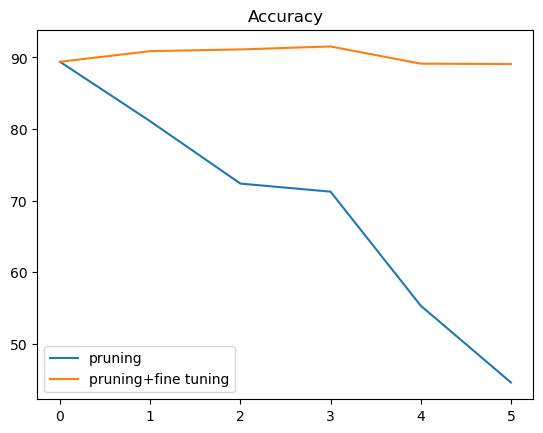

In [11]:
a = list(range(6))
b = make_list(_acc_50)

x = list(range(6))
y = make_list(acc_50)

plt.title('Accuracy')
plt.plot(a,b, label = 'pruning')
plt.plot(x,y, label = 'pruning+fine tuning')
plt.legend()

plt.show()

# pruning ratio : 60%

In [13]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_60, acc_60, params_60, mmac_60, inference_time_60, df_60 = pruning_finetuning(model, 0.6, device, test_loader)
df_60

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.921124
step 1,90.869995,47227,328973,6.564140
step 2,91.08,35143,240899,6.541562
step 3,89.19,24535,164201,6.481123
step 4,88.77,16297,140715,6.541610
step 5,86.27,9563,82741,6.504798


# lr 1e-3

In [7]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_60, acc_60, params_60, mmac_60, inference_time_60, df_60 = pruning_finetuning(model, 0.6, device, test_loader)
df_60

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,9.424424
step 1,93.479996,47227,328973,6.498671
step 2,94.9,35143,240899,6.426024
step 3,94.29,24535,164201,6.420755
step 4,93.46999,16297,140715,6.437135
step 5,90.23,9563,82741,6.421614


# Pruning ratio: 70%

In [15]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_70, acc_70, params_70, mmac_70, inference_time_70, df_70 = pruning_finetuning(model, 0.7, device, test_loader)
df_70

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.948780
step 1,90.84,43564,312736,6.613135
step 2,90.79,30781,226438,6.471896
step 3,88.54,20206,152248,6.481433
step 4,86.71999,11839,90166,6.442976
step 5,77.11,4951,36789,6.062365


# pruning ratio : 80%

In [17]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_80, acc_80, params_80, mmac_80, inference_time_80, df_80 = pruning_finetuning(model, 0.8, device, test_loader)
df_80

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.955623
step 1,90.79,42148,311320,6.333208
step 2,90.26,26699,212257,6.391430
step 3,88.02,16297,140715,6.322432
step 4,84.17,7355,75384,5.978727
step 5,72.22,2406,31570,6.077576


# pruning ratio : 90%

In [19]:
# pruning + finetuning
model = copy.deepcopy(origin_model)

model_90, acc_90, params_90, mmac_90, inference_time_90, df_90 = pruning_finetuning(model, 0.9, device, test_loader)
df_90

,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.645154
step 1,89.95,40787,256642,6.591463
step 2,88.78,24535,164201,6.498837
step 3,84.57,12607,90934,6.718230
step 4,73.74,4485,36323,6.247830
step 5,43.93,524,24340,6.166220


## * FINAL RESULTS

(comparison of the four metrics based on pruning ratio)

In [47]:
import pandas as pd
pd.DataFrame({'acc(%)':[acc_50[0], acc_50[-1], acc_60[-1], acc_70[-1], acc_80[-1], acc_90[-1]],
              'n_params' : [params_50[0], params_50[-1], params_60[-1], params_70[-1], params_80[-1], params_90[-1]],
              'MACs': [mmac_50[0], mmac_50[-1], mmac_60[-1], mmac_70[-1], mmac_80[-1], mmac_90[-1]],
              'inference time(μs)': [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]],},
             index = ['Base'] + [f'{i}%' for i in range(50, 100, 10)])


,acc(%),n_params,MACs,inference time(μs)
Base,89.39,61706,429342,7.692027
50%,89.08,15738,140156,6.632090
60%,86.27,9563,82741,6.504798
70%,77.11,4951,36789,6.062365
80%,72.22,2406,31570,6.077576
90%,43.93,524,24340,6.166220


### * VERIFY if pruning followed the set pruning ratio

In [39]:
def num_channel(model): 
    total = 0
    for param_tensor in list(origin_model.state_dict().keys())[:-2]:
        total += model.state_dict()[param_tensor].shape[0]
    return total

base = num_channel(origin_model)

def calc_ratio(model):
    total = num_channel(model)
    ratio = round(1- total / base, 1) 
    return total, ratio 

In [40]:
c_50 = calc_ratio(model_50)
c_60 = calc_ratio(model_60)
c_70 = calc_ratio(model_70)
c_80 = calc_ratio(model_80)
c_90 = calc_ratio(model_90)

print('################# number of channels ##################')
print(f"Base: {base}")
print(f"50%: {c_50[0]} channels  -> pruned ratio: {c_50[1]}")
print(f"60%: {c_60[0]} channels  -> pruned ratio: {c_60[1]}")
print(f"70%: {c_70[0]} channels  -> pruned ratio: {c_70[1]}")
print(f"80%: {c_80[0]} channels   -> pruned ratio: {c_80[1]}")
print(f"90%: {c_90[0]} channels   -> pruned ratio: {c_90[1]}")

################# number of channels ##################
Base: 452
50%: 226 channels  -> pruned ratio: 0.5
60%: 178 channels  -> pruned ratio: 0.6
70%: 132 channels  -> pruned ratio: 0.7
80%: 86 channels   -> pruned ratio: 0.8
90%: 42 channels   -> pruned ratio: 0.9


### * Select a pruning ratio of **60%** for quantization

In [20]:
# Base model params
from torchsummary import summary
summary(origin_model, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [21]:
# pruned 60% model params
summary(model_60, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 28, 28]              52
         MaxPool2d-2            [-1, 2, 14, 14]               0
            Conv2d-3            [-1, 6, 10, 10]             306
         MaxPool2d-4              [-1, 6, 5, 5]               0
            Linear-5                   [-1, 48]           7,248
            Linear-6                   [-1, 33]           1,617
            Linear-7                   [-1, 10]             340
Total params: 9,563
Trainable params: 9,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.04
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [24]:
#torch.save(model_60.state_dict(), 'model_60.pth')

# [ Quantization ]

In [25]:
quantize_qint8_model60 = quantize_qint8(model_60.to('cpu'))
quantize_qint8_model60

# Linear -> DynamicQuantizedLinear 

LeNet_5(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): DynamicQuantizedLinear(in_features=150, out_features=48, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=48, out_features=33, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=33, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [41]:
print('#########################################')
print('########### Before Quantization #########')
print('#########################################')

acc, inference_time = test(model_60.to('cpu'), 'cpu', test_loader)
macs, nparams = tp.utils.count_ops_and_params(model_60.to('cpu'), torch.randn(1, 1, 32, 32))

print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
print('n_params:', nparams)
print('macs:', macs)

print()
print('#########################################')
print('############ After Quantization #########')
print('#########################################')

acc, inference_time = test(quantize_qint8_model60, 'cpu', test_loader)
macs, nparams = tp.utils.count_ops_and_params(quantize_qint8_model60, torch.randn(1, 1, 32, 32))

print(f'accuracy: {acc.item():.3f}\ninference time: {inference_time:.3f}μs')
print('n_params:', nparams)
print('macs:', macs)

#########################################
########### Before Quantization #########
#########################################
accuracy: 86.270
inference time: 16.519μs
n_params: 9563
macs: 82741.0

#########################################
############ After Quantization #########
#########################################
accuracy: 86.280
inference time: 17.779μs
n_params: 358
macs: 73536.0


### Summary of Base

In [27]:
summary(origin_model.to('cpu'), (1,32,32), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 6, 28, 28]             156
         MaxPool2d-2            [32, 6, 14, 14]               0
            Conv2d-3           [32, 16, 10, 10]           2,416
         MaxPool2d-4             [32, 16, 5, 5]               0
            Linear-5                  [32, 120]          48,120
            Linear-6                   [32, 84]          10,164
            Linear-7                   [32, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 1.98
Params size (MB): 0.24
Estimated Total Size (MB): 2.34
----------------------------------------------------------------


### Summary of pruned 60%

In [28]:
summary(model_60, (1,32,32), batch_size=32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 2, 28, 28]              52
         MaxPool2d-2            [32, 2, 14, 14]               0
            Conv2d-3            [32, 6, 10, 10]             306
         MaxPool2d-4              [32, 6, 5, 5]               0
            Linear-5                   [32, 48]           7,248
            Linear-6                   [32, 33]           1,617
            Linear-7                   [32, 10]             340
Total params: 9,563
Trainable params: 9,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.68
Params size (MB): 0.04
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


### Summary of pruned + quantized model

In [29]:
from torchsummary import summary
summary(quantize_qint8_model60, (1,32,32), batch_size=32, device='cpu')


# using torchsummary, parameters for FCL are all recorded as 0

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 2, 28, 28]              52
         MaxPool2d-2            [32, 2, 14, 14]               0
            Conv2d-3            [32, 6, 10, 10]             306
         MaxPool2d-4              [32, 6, 5, 5]               0
            Linear-5                   [32, 48]               0
            Linear-6                   [32, 33]               0
            Linear-7                   [32, 10]               0
Total params: 358
Trainable params: 358
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.68
Params size (MB): 0.00
Estimated Total Size (MB): 0.81
----------------------------------------------------------------


After quantization, the number of parameters changed from 9563 -> 348. Why?

Check why the model parameters decrease after quantization











In [30]:
quantize_qint8_model60.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.scale', 'fc1.zero_point', 'fc1._packed_params.dtype', 'fc1._packed_params._packed_params', 'fc2.scale', 'fc2.zero_point', 'fc2._packed_params.dtype', 'fc2._packed_params._packed_params', 'fc3.scale', 'fc3.zero_point', 'fc3._packed_params.dtype', 'fc3._packed_params._packed_params'])

In [31]:
fc_list = ['fc1', 'fc2', 'fc3']
fc_nparams = []

for i in fc_list:
    n = i + '._packed_params._packed_params'
    weight = quantize_qint8_model60.state_dict()[n][0].numel()
    bias = quantize_qint8_model60.state_dict()[n][1].numel()

    fc_nparams.append(weight+bias)

# After Quantization 
print('################# check number of Parameters after quantization ##################')
for idx, i in enumerate(fc_nparams):
    print(f'fc{idx+1}:', i)
    
# same !!
# It is correct that the number of parameters has not changed

################# check number of Parameters after quantization ##################
fc1: 7248
fc2: 1617
fc3: 340


After quantization, the model's parameter storage format changes

-> the total number of parameters remains the same when added up.

## * CHECK THE CHANGED PRAMETER SIZE

In [53]:
import os

def params_size(model, model_name):
    torch.save(model.state_dict(), model_name + '.p')
    size = os.path.getsize(model_name + '.p')
    return round(size / 1024)  # to KB

base = params_size(origin_model, "origin_model")
pruned_60 = params_size(model_60, "model_60")
quantized_60 = params_size(quantize_qint8_model60, "quantized_model60")

print('################# Parameter Size Comparison ##################')
print(f"Base Model Size: {base} KB")
print(f"60% Pruned Model Size: {pruned_60} KB  -> Reduction: {round((1 - pruned_60 / base) * 100, 2)}%")
print(f"60% Pruned + Quantized Model Size: {quantized_60} KB  -> Reduction: {round((1 - quantized_60 / base) * 100, 2)}%")

pd.DataFrame({'acc(%)': [acc_60[0], acc_60[-1], acc.numpy()],
             'param size(KB)': [base, pruned_60, quantized_60],
              },
             index = ['Base', '60% pruned', '60% pruned+quantization'])


################# Parameter Size Comparison ##################
Base Model Size: 245 KB
60% Pruned Model Size: 41 KB  -> Reduction: 83.27%
60% Pruned + Quantized Model Size: 16 KB  -> Reduction: 93.47%


,acc(%),param size(KB)
Base,89.39,245
60% pruned,86.27,41
60% pruned+quantization,86.28,16


In [33]:
# 젯슨나노에 올릴 모델 저장
torch.save(model_60, 'model_60.pth')

### * Visualization across Pruning Ratios

### accuracy

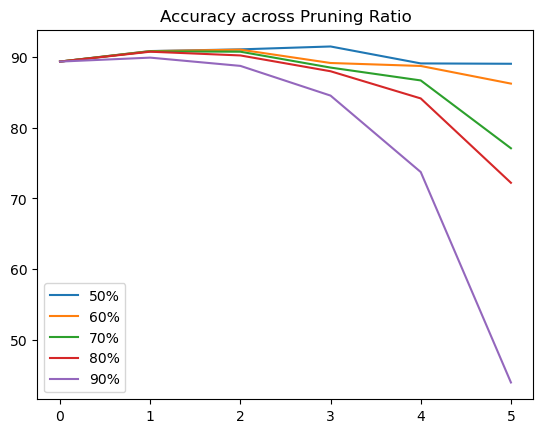

In [34]:
x = list(range(6))

plt.title('Accuracy across Pruning Ratio')
plt.plot(x, make_list(acc_50), label='50%')
plt.plot(x, make_list(acc_60), label='60%')
plt.plot(x, make_list(acc_70), label='70%')
plt.plot(x, make_list(acc_80), label='80%')
plt.plot(x, make_list(acc_90), label='90%')
plt.legend()

plt.show()

### params

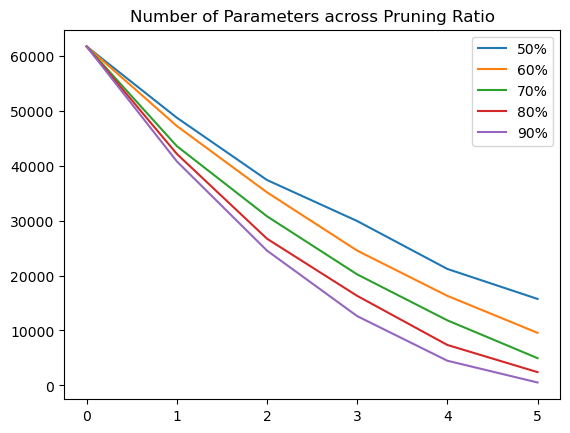

In [38]:
x = list(range(6))

plt.title('Number of Parameters across Pruning Ratio')
plt.plot(x, params_50, label='50%')
plt.plot(x, params_60, label='60%')
plt.plot(x, params_70, label='70%')
plt.plot(x, params_80, label='80%')
plt.plot(x, params_90, label='90%')
plt.legend()

plt.show()

### MACs

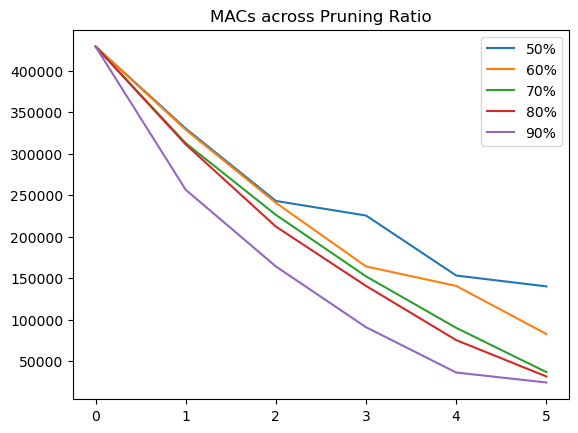

In [36]:
x = list(range(6))

plt.title('MACs across Pruning Ratio')
plt.plot(x, mmac_50, label='50%')
plt.plot(x, mmac_60, label='60%')
plt.plot(x, mmac_70, label='70%')
plt.plot(x, mmac_80, label='80%')
plt.plot(x, mmac_90, label='90%')
plt.legend()

plt.show()

## Inference time

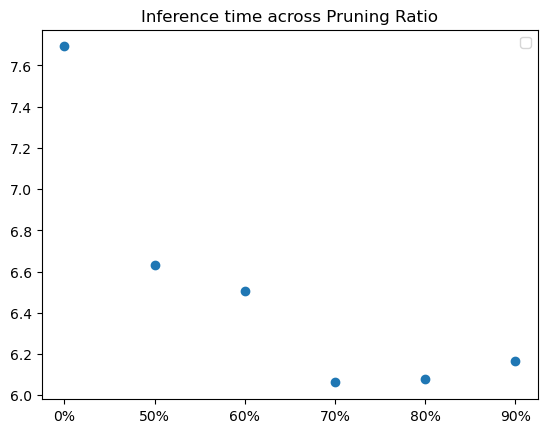

In [42]:
x = ['0%'] + [str(i) + '%' for i in range(50, 100, 10)]
y = [inference_time_50[0], inference_time_50[-1], inference_time_60[-1], inference_time_70[-1], inference_time_80[-1], inference_time_90[-1]]
plt.title('Inference time across Pruning Ratio')
plt.scatter(x, y)
plt.legend()

plt.show()